<center><h1>Sun_Kaiyi_Project</h1></center>

Name: Kaiyi Sun 
<br>
Github Username: KaiyiSss
<br>
USC ID: 6511379529

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pathlib 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
VAL_RATIO = 0.15
PATIENCE = 3
TRAIN_PERCEN = 0.7
TEST_PERCEN = 1
VAL_PERCEN = 0.15
EPOCHS = 50
FIT_BATCH = 128

In [3]:
data_images = '../data/Sport Images'
data_video = '../data/Sport Videos'

### Create Dataset

In [4]:
def split_folders(image_path, label_count):
    # Read each image file directory
    dataset = tf.keras.utils.image_dataset_from_directory(image_path,labels=None,label_mode='int',color_mode='rgb',batch_size=None,image_size=IMG_SIZE,seed=20)
    # Map dataset to labels
    dataset = dataset.map(lambda x: (x, label_count))
    # Calcualte numbero f files that should be in each dataset
    total_file = len(dataset)
    train_size, val_size = int(np.ceil(total_file*TRAIN_PERCEN)), int(np.ceil(total_file*VAL_PERCEN))
    test_size = int(TEST_PERCEN*(total_file - (train_size + val_size)))
    # Split files
    train = dataset.take(train_size)
    val = dataset.skip(train_size).take(val_size)
    test = dataset.skip(train_size + val_size).take(test_size)
    return [train, val, test]

In [5]:
classes = ['baseball','basketball','fencing','tennis','volleyball']
data_sets = []
for idx in range(len(classes)):
    data_sets.append(split_folders(data_images+'/'+classes[idx], idx))

Found 734 files belonging to 1 classes.
Found 492 files belonging to 1 classes.
Found 634 files belonging to 1 classes.
Found 715 files belonging to 1 classes.
Found 704 files belonging to 1 classes.


In [6]:
train, val, test = data_sets[0][0],data_sets[0][1],data_sets[0][2]
for t, v, tst in data_sets[1:]:
    train = train.concatenate(t)
    val = val.concatenate(v)
    test = test.concatenate(tst)

### Proprocessing Images

In [7]:
# Augmentation functions
image_augmentation_zoom = tf.keras.layers.RandomZoom((-0.1, 0.4))
image_augmentation_translation = tf.keras.layers.RandomTranslation((-0.1, 0.5), (-0.2, 0.4))
image_augmentation_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
image_augmentation_rotation = tf.keras.layers.RandomRotation((-0.1, 0.3))
image_augmentation_brightness = tf.keras.layers.RandomBrightness(0.6)
image_augmentation_contrast = tf.keras.layers.RandomContrast(0.3)

In [8]:
def chooseRandom(img):
    choice = [0,1]
    np.random.shuffle(choice)
    # Based on random value choose augmentation type
    if choice == 1:
        return image_augmentation_zoom(image_augmentation_rotation(image_augmentation_brightness(image_augmentation_translation(img))))
    else:
        return image_augmentation_contrast(image_augmentation_flip(img))

In [9]:
dataset_random_augmentation = train.map(lambda i,l:(chooseRandom(i), l))
dataset_zoomed = train.map(lambda i,l:(image_augmentation_zoom(i), l))
dataset_flip = train.map(lambda i,l:(image_augmentation_flip(i), l))
dataset_rotated = train.map(lambda i,l:(image_augmentation_rotation(i), l))
dataset_bright = train.map(lambda i,l:(image_augmentation_brightness(i), l))

In [10]:
augmented_train = train.concatenate(dataset_random_augmentation)
augmented_train = augmented_train.concatenate(dataset_zoomed)
augmented_train = augmented_train.concatenate(dataset_flip)
augmented_train = augmented_train.concatenate(dataset_bright)

In [11]:
# Form batches
batched_augmented_train = augmented_train.batch(128, drop_remainder=True)
batched_test = test.batch(128, drop_remainder=True)
batched_val = val.batch(128, drop_remainder=True)

In [12]:
batched_augmented_train

<BatchDataset element_spec=(TensorSpec(shape=(128, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>

In [13]:
batched_val

<BatchDataset element_spec=(TensorSpec(shape=(128, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>

In [14]:
batched_test

<BatchDataset element_spec=(TensorSpec(shape=(128, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>

### Creating Model

In [15]:
def modelCreation(base):
    for layer in base.layers:
        layer.trainable = False
    model = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(base.output)
    model = tf.keras.layers.Flatten()(model)
    model = tf.keras.layers.Dense(32, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.2)(model)
    model = tf.keras.layers.BatchNormalization()(model)
    model_prediction = tf.keras.layers.Dense(5, activation = 'softmax')(model)
    model_final = tf.keras.Model(inputs = base.input, outputs = model_prediction)
    model_final.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model_final

In [16]:
resnet = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))
efficient = tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))
vgg = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
resnet_model = modelCreation(resnet)
efficient_model = modelCreation(efficient)
vgg_model = modelCreation(vgg)

In [18]:
# Early stop object to restore weights to best epoch
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, mode='min', restore_best_weights=True)

In [19]:
resnet_history = resnet_model.fit(batched_augmented_train, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_val)

Epoch 1/50
89/89 [==============================] - 79s 764ms/step - loss: 1.7884 - accuracy: 0.2204 - val_loss: 1.4488 - val_accuracy: 0.2943
Epoch 2/50
89/89 [==============================] - 63s 701ms/step - loss: 1.6570 - accuracy: 0.2364 - val_loss: 1.4091 - val_accuracy: 0.7318
Epoch 3/50
89/89 [==============================] - 62s 682ms/step - loss: 1.6261 - accuracy: 0.2521 - val_loss: 1.3214 - val_accuracy: 0.8646
Epoch 4/50
89/89 [==============================] - 62s 683ms/step - loss: 1.6106 - accuracy: 0.2651 - val_loss: 1.2534 - val_accuracy: 0.8698
Epoch 5/50
89/89 [==============================] - 63s 699ms/step - loss: 1.5994 - accuracy: 0.2767 - val_loss: 1.2072 - val_accuracy: 0.8385
Epoch 6/50
89/89 [==============================] - 63s 698ms/step - loss: 1.5930 - accuracy: 0.2874 - val_loss: 1.1293 - val_accuracy: 0.8984
Epoch 7/50
89/89 [==============================] - 62s 682ms/step - loss: 1.5863 - accuracy: 0.3027 - val_loss: 1.1621 - val_accuracy: 0.9062

In [20]:
efficient_history = efficient_model.fit(batched_augmented_train, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_val)

Epoch 1/50


2023-05-09 15:09:02.009570: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


89/89 [==============================] - 62s 621ms/step - loss: 1.8203 - accuracy: 0.2351 - val_loss: 0.8739 - val_accuracy: 0.7969
Epoch 2/50
89/89 [==============================] - 56s 621ms/step - loss: 1.6680 - accuracy: 0.2737 - val_loss: 0.9743 - val_accuracy: 0.8620
Epoch 3/50
89/89 [==============================] - 55s 604ms/step - loss: 1.6278 - accuracy: 0.2918 - val_loss: 0.9525 - val_accuracy: 0.9036
Epoch 4/50
89/89 [==============================] - 56s 616ms/step - loss: 1.6061 - accuracy: 0.3141 - val_loss: 1.0136 - val_accuracy: 0.9349
Epoch 4: early stopping


In [21]:
vgg_history = vgg_model.fit(batched_augmented_train, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_val)

Epoch 1/50
89/89 [==============================] - 72s 671ms/step - loss: 1.8139 - accuracy: 0.2175 - val_loss: 1.3228 - val_accuracy: 0.4714
Epoch 2/50
89/89 [==============================] - 61s 677ms/step - loss: 1.6660 - accuracy: 0.2287 - val_loss: 1.3186 - val_accuracy: 0.6016
Epoch 3/50
89/89 [==============================] - 60s 667ms/step - loss: 1.6325 - accuracy: 0.2555 - val_loss: 1.3580 - val_accuracy: 0.6328
Epoch 4/50
89/89 [==============================] - 61s 674ms/step - loss: 1.6167 - accuracy: 0.2643 - val_loss: 1.3141 - val_accuracy: 0.7005
Epoch 5/50
89/89 [==============================] - 60s 670ms/step - loss: 1.6050 - accuracy: 0.2757 - val_loss: 1.4249 - val_accuracy: 0.7552
Epoch 6/50
89/89 [==============================] - 62s 684ms/step - loss: 1.5985 - accuracy: 0.2769 - val_loss: 1.3756 - val_accuracy: 0.8333
Epoch 7/50
89/89 [==============================] - 62s 689ms/step - loss: 1.5939 - accuracy: 0.2766 - val_loss: 1.3021 - val_accuracy: 0.8385

### Evaluation of models

In [22]:
def plotLossVSEpoch(model_history, model):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('{} Loss vs Epoch'.format(model))
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

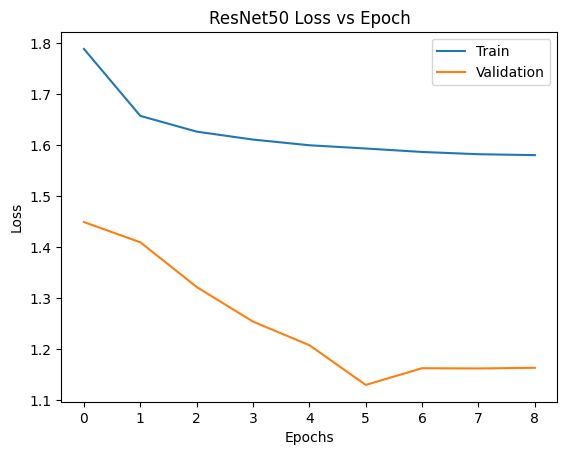

In [23]:
plotLossVSEpoch(resnet_history, 'ResNet50')

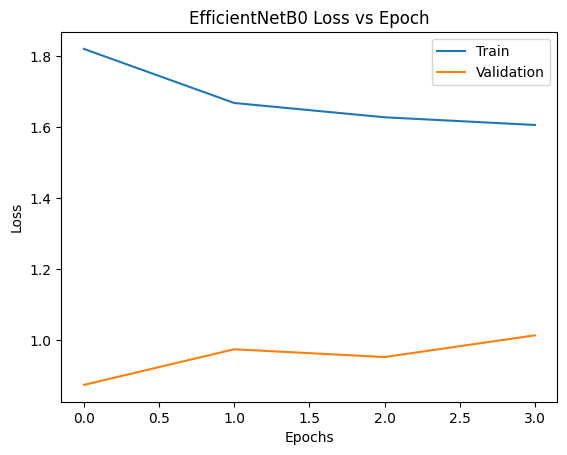

In [24]:
plotLossVSEpoch(efficient_history, 'EfficientNetB0')

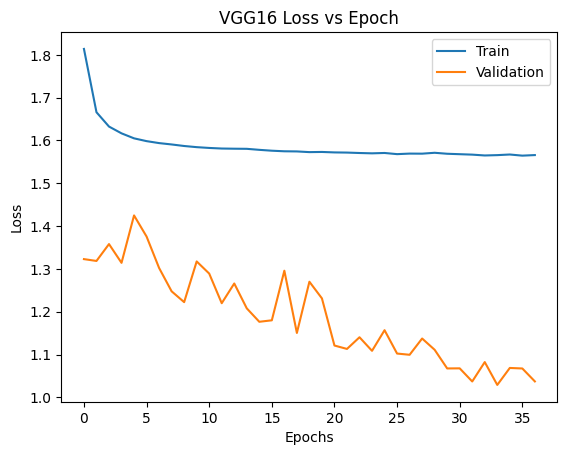

In [25]:
plotLossVSEpoch(vgg_history, 'VGG16')

### Image class predictions

#### Train

In [26]:
# Model prediction
train_resnet_probabilities = resnet_model.predict(batched_augmented_train)
train_efficient_probabilities = efficient_model.predict(batched_augmented_train)
train_vgg_probabilities = vgg_model.predict(batched_augmented_train)

# pick max index for each model prediction
train_resnet_prediction = np.argmax(train_resnet_probabilities, axis=1)
train_efficient_prediction = np.argmax(train_efficient_probabilities, axis=1)
train_vgg_prediction = np.argmax(train_vgg_probabilities, axis=1)

89/89 [==============================] - 59s 656ms/step


#### Test

In [27]:
# Test dataset predictions
test_resnet_probabilities = resnet_model.predict(batched_test)
test_efficient_probabilities = efficient_model.predict(batched_test)
test_vgg_probabilities = vgg_model.predict(batched_test)

# Pick index with highest probabilty
test_resnet_prediction = np.argmax(test_resnet_probabilities, axis=1)
test_efficient_prediction = np.argmax(test_efficient_probabilities, axis=1)
test_vgg_prediction = np.argmax(test_vgg_probabilities, axis=1)

3/3 [==============================] - 6s 2s/step


### Model Stat Analysis

In [28]:
# Cited from the url: https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification

# Calcualtes accuracy of predictions
def findaccuracy(y_true, y_pred):
    correct_predictions = 0    
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:            
            correct_predictions += 1
    return correct_predictions / len(y_true)

# Confusion matrix
# True Positive for multiclass
def true_positive(y_true, y_pred):
    tp = 0
    for yt, yp in zip(y_true, y_pred):        
        if yt == 1 and yp == 1:
            tp += 1
    return tp

# True Negative for multiclass
def true_negative(y_true, y_pred):    
    tn = 0
    for yt, yp in zip(y_true, y_pred):        
        if yt == 0 and yp == 0:
            tn += 1
    return tn

# False Positive for multiclass
def false_positive(y_true, y_pred):    
    fp = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 0 and yp == 1:
            fp += 1            
    return fp

# False Negative for multiclass
def false_negative(y_true, y_pred):
    fn = 0    
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 0:
            fn += 1            
    return fn

# Computation of macro-averaged precision
'''
Method: Find precision by taking a sinlge class as positive and other as negative
Repeat for all classes and avg
'''
def macro_precision(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    precision = 0
    for class_ in np.unique(y_true):
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        tp = true_positive(temp_true, temp_pred)
        fp = false_positive(temp_true, temp_pred)
        temp_precision = tp / (tp + fp + 1e-6)
        precision += temp_precision
    precision /= num_classes
    return precision

'''
Method: Find recall by taking a sinlge class as positive and other as negative
Repeat for all classes and avg
'''
def macro_recall(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    recall = 0
    for class_ in np.unique(y_true):
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        tp = true_positive(temp_true, temp_pred)
        fn = false_negative(temp_true, temp_pred)
        temp_recall = tp / (tp + fn + 1e-6)
        recall += temp_recall
    recall /= num_classes
    return recall

#### F1-score

In [30]:
'''
Method: Find F1 by taking a sinlge class as positive and other as negative
Repeat for all classes and avg
'''
def macro_f1(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    f1 = 0
    for class_ in np.unique(y_true):
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        tp = true_positive(temp_true, temp_pred)
        fn = false_negative(temp_true, temp_pred)
        fp = false_positive(temp_true, temp_pred)
        temp_recall = tp / (tp + fn + 1e-6)
        temp_precision = tp / (tp + fp + 1e-6)
        temp_f1 = 2 * temp_precision * temp_recall / (temp_precision + temp_recall + 1e-6)
        f1 += temp_f1
    f1 /= num_classes
    return f1

In [31]:
# Method to print required result
def printResults(model_name, y_true, y_prediction):
    print("Results for model {}".format(model_name))
    cm = confusion_matrix( y_true, y_prediction)
    print("Confusion Matrix:\n", cm)

    precision = macro_precision( y_true, y_prediction)
    recall = macro_recall( y_true, y_prediction)
    accuracy = findaccuracy( y_true, y_prediction)
    f1 = macro_f1( y_true, y_prediction)

    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

In [32]:
# Convert train and test prediction from batches to 1d array
testing_labels = []
for img, label in (batched_test.take(len(batched_test))):
    testing_labels += list(label.numpy())
testing_labels = np.array(testing_labels)

training_labels = []
for img, label in (batched_augmented_train.take(len(batched_augmented_train))):
    training_labels += list(label.numpy())
training_labels = np.array(training_labels)

#### Train Datasets

In [33]:
printResults('ResNet50', training_labels, train_resnet_prediction)

Results for model ResNet50
Confusion Matrix:
 [[2245    6  230   75   14]
 [  76 1453   39   48  109]
 [  25    1 2170    9   15]
 [ 479    6  176 1816   28]
 [  34   37  538   53 1710]]
Precision: 0.8518532614193439
Recall: 0.8278395791945842
Accuracy: 0.8246137640449438
F1 Score: 0.8292297778993468


In [34]:
printResults('EfficientNetB0', training_labels, train_efficient_prediction)

Results for model EfficientNetB0
Confusion Matrix:
 [[1765   50  476  262   17]
 [  61 1393  112  124   35]
 [  31    7 2130   33   19]
 [ 369  133  740 1222   41]
 [  21  265  742  212 1132]]
Precision: 0.723172294865037
Recall: 0.6837649740884146
Accuracy: 0.6708216292134831
F1 Score: 0.6726042178033259


In [35]:
printResults('VGG16', training_labels, train_vgg_prediction)

Results for model VGG16
Confusion Matrix:
 [[2378    2  138   41   11]
 [   3 1655    0   34   33]
 [  62    0 2148    4    6]
 [1197   33   23 1218   34]
 [  46   57  170   66 2033]]
Precision: 0.8625797457196216
Recall: 0.8391179719820989
Accuracy: 0.8279494382022472
F1 Score: 0.8326716635963777


VGG16 and ResNet50 perform the best when tested on training data. Efficient is much lower, this is because it only ran for a few epochs

#### Test Datasets

In [36]:
printResults('ResNet50', testing_labels, test_resnet_prediction)

Results for model ResNet50
Confusion Matrix:
 [[102   1   3   3   0]
 [  2  65   1   3   2]
 [  1   0  91   0   2]
 [ 19   0   2  84   1]
 [  0   0   0   0   2]]
Precision: 0.7929241993080717
Recall: 0.917345634686497
Accuracy: 0.8958333333333334
F1 Score: 0.8130505369286201


In [37]:
printResults('EfficientNetB0', testing_labels, test_efficient_prediction)

Results for model EfficientNetB0
Confusion Matrix:
 [[79  1 20  8  1]
 [ 1 62  6  3  1]
 [ 0  0 91  2  1]
 [18  6 36 46  0]
 [ 0  0  0  0  2]]
Precision: 0.6958210628092613
Recall: 0.7952265097105344
Accuracy: 0.7291666666666666
F1 Score: 0.7004736724245362


In [38]:
printResults('VGG16', testing_labels, test_vgg_prediction)

Results for model VGG16
Confusion Matrix:
 [[104   0   5   0   0]
 [  0  73   0   0   0]
 [  1   0  93   0   0]
 [ 37   0   0  69   0]
 [  0   0   0   0   2]]
Precision: 0.9362746830003225
Recall: 0.9188865999206192
Accuracy: 0.8880208333333334
F1 Score: 0.9172007358685648


Overall VGG16 and ResNet50 peroform better than EfficientNetB0 but as aforementioned this is likely due to the low train done on the model.

### Analysis Video Frames

Could not run for all 3 models due to time constraint so decided to pick VGG as it has similar performance to ResNet but a bette rF1 score.

##### Retrain all models using Validation as training and Test as validation to avoid overfitting

In [39]:
vide_resnet_history = resnet_model.fit(batched_val, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_test)

Epoch 1/50
3/3 [==============================] - 12s 4s/step - loss: 1.3502 - accuracy: 0.5911 - val_loss: 1.1356 - val_accuracy: 0.8880
Epoch 2/50
3/3 [==============================] - 12s 5s/step - loss: 1.3368 - accuracy: 0.5911 - val_loss: 1.0864 - val_accuracy: 0.9089
Epoch 3/50
3/3 [==============================] - 11s 5s/step - loss: 1.3237 - accuracy: 0.6094 - val_loss: 1.0795 - val_accuracy: 0.9141
Epoch 4/50
3/3 [==============================] - 16s 7s/step - loss: 1.2905 - accuracy: 0.6068 - val_loss: 1.0378 - val_accuracy: 0.9323
Epoch 5/50
3/3 [==============================] - 11s 4s/step - loss: 1.2630 - accuracy: 0.5964 - val_loss: 0.9936 - val_accuracy: 0.8932
Epoch 6/50
3/3 [==============================] - 11s 4s/step - loss: 1.2400 - accuracy: 0.5885 - val_loss: 0.9455 - val_accuracy: 0.9271
Epoch 7/50
3/3 [==============================] - 12s 5s/step - loss: 1.2105 - accuracy: 0.5964 - val_loss: 0.8849 - val_accuracy: 0.9036
Epoch 8/50
3/3 [==================

In [40]:
vide_efficient_history = efficient_model.fit(batched_val, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_test)

Epoch 1/50
3/3 [==============================] - 11s 4s/step - loss: 1.4456 - accuracy: 0.4453 - val_loss: 0.8221 - val_accuracy: 0.7865
Epoch 2/50
3/3 [==============================] - 10s 4s/step - loss: 1.3347 - accuracy: 0.4740 - val_loss: 0.7654 - val_accuracy: 0.7292
Epoch 3/50
3/3 [==============================] - 11s 4s/step - loss: 1.2311 - accuracy: 0.5443 - val_loss: 0.7587 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 10s 4s/step - loss: 1.1960 - accuracy: 0.5391 - val_loss: 0.6915 - val_accuracy: 0.7604
Epoch 5/50
3/3 [==============================] - 10s 4s/step - loss: 1.1648 - accuracy: 0.5625 - val_loss: 0.5610 - val_accuracy: 0.8646
Epoch 6/50
3/3 [==============================] - 10s 4s/step - loss: 1.1300 - accuracy: 0.5495 - val_loss: 0.4956 - val_accuracy: 0.8542
Epoch 7/50
3/3 [==============================] - 10s 4s/step - loss: 1.0890 - accuracy: 0.6016 - val_loss: 0.3553 - val_accuracy: 0.9167
Epoch 8/50
3/3 [==================

In [41]:
vide_vgg_history = vgg_model.fit(batched_val, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_test)

Epoch 1/50
3/3 [==============================] - 11s 5s/step - loss: 1.2228 - accuracy: 0.7292 - val_loss: 1.0310 - val_accuracy: 0.8620
Epoch 2/50
3/3 [==============================] - 11s 4s/step - loss: 1.2066 - accuracy: 0.7266 - val_loss: 0.9984 - val_accuracy: 0.8776
Epoch 3/50
3/3 [==============================] - 10s 4s/step - loss: 1.1836 - accuracy: 0.7240 - val_loss: 1.0115 - val_accuracy: 0.8411
Epoch 4/50
3/3 [==============================] - 11s 4s/step - loss: 1.1689 - accuracy: 0.7318 - val_loss: 0.9371 - val_accuracy: 0.8542
Epoch 5/50
3/3 [==============================] - 10s 4s/step - loss: 1.1529 - accuracy: 0.6927 - val_loss: 0.9193 - val_accuracy: 0.8776
Epoch 6/50
3/3 [==============================] - 11s 4s/step - loss: 1.1335 - accuracy: 0.7135 - val_loss: 0.8880 - val_accuracy: 0.8672
Epoch 7/50
3/3 [==============================] - 11s 5s/step - loss: 1.1030 - accuracy: 0.6849 - val_loss: 0.8861 - val_accuracy: 0.8724
Epoch 8/50
3/3 [==================

#### Predicting Sport by Video

In [42]:
frames_split = 100

def preprocess_frame(img):
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = np.expand_dims(img, axis=0)
    return img

In [43]:
# Get all files and labels from the video directories
def getFilesLabels():
    directory_video_Files = pathlib.Path('../data/Sport Videos')
    video_file_paths = []
    video_file_labels = []
    folder_to_class = {'BaseballPitch':0,'Basketball':1,'Fencing':2,'TennisSwing':3,'VolleyballSpiking':4}
    # Get files that are .avi only
    for video_path in directory_video_Files.glob('**/*.avi'):
        file_folder_name = os.path.basename(os.path.dirname(video_path)).split('/')[-1]
        video_file_labels.append(folder_to_class[file_folder_name])
        video_file_paths.append(str(video_path))
    return video_file_paths, video_file_labels

In [44]:
file_paths, y_true = getFilesLabels()

In [45]:
# Predict the video class
def videoPrediction(path):
    vgg_model_prediction = [] 
    # Verify file type
    if str(path)[-4:] == '.avi':
        picked_frames =[]
        cap = cv2.VideoCapture(str(path))
        video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        # https://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
        # https://towardsdatascience.com/lightning-fast-video-reading-in-python-c1438771c4e6
        success = cap.grab()
        while success:
            '''
            if video size smaller than 100 take whole otherwise always take atleast 100 or 50% of video if video is much larger than 100
            '''
            if (len(picked_frames) < int(frames_split) or (len(picked_frames)/video_length) < 0.5):
                success, img = cap.retrieve()
                frame = preprocess_frame(img) # Frame as input to prediction
                vgg_model_prediction.append(vgg_model.predict(frame,verbose=0))
                success = cap.grab()
        cap.release()
    vgg_prediction = np.argmax(np.mean(vgg_model_prediction, axis=0))
    tf.keras.backend.clear_session()
    return vgg_prediction

In [46]:
predicted_list = list(map(videoPrediction, tqdm(file_paths)))

100%|██████████| 681/681 [1:34:31<00:00,  8.33s/it]


In [47]:
predicted_list

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 4,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 3,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


### Video Prediction Analysis

In [48]:
printResults('VGG16', y_true, predicted_list)

Results for model VGG16
Confusion Matrix:
 [[126   0  20   4   0]
 [ 34   0 100   3   0]
 [  3   0 108   0   0]
 [105   0  39  23   0]
 [  2   1 110   0   3]]
Precision: 0.5039610240994804
Recall: 0.395311915484705
Accuracy: 0.38179148311306904
F1 Score: 0.2653089062213302


Conclusion: The VGG models pretty well for being trained so little it leads to an accuracy of 0.38. The model is particulary choosing class 0 and 2 more than the others which could be due to the lack of train or imbalanced data.

### References

https://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames

https://towardsdatascience.com/lightning-fast-video-reading-in-python-c1438771c4e6

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take

https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification